# Übung 4: Supportvektormaschinen mit SciKit Learn, Random Forests und Boosting

## 1. Klassifikation mit SVMs

In [81]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import skimage as ski
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d

np.set_printoptions(suppress=True, linewidth=np.inf)
sns.set_style("darkgrid")

%reload_ext version_information
%version_information numpy, pandas, seaborn, sklearn, skimage, random, matplotlib, mpl_toolkits

Software,Version
Python,3.7.4 64bit [GCC 7.3.0]
IPython,7.8.0
OS,Linux 4.15.0 70 generic x86_64 with debian buster sid
numpy,1.17.2
pandas,0.25.1
seaborn,0.9.0
sklearn,0.21.3
skimage,0.15.0
random,The 'random' distribution was not found and is required by the application
matplotlib,3.1.1


### a) Einlesen, Vorverarbeiten und Anzeigen der Daten

/home/henning/anaconda3/envs/base_mldl/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


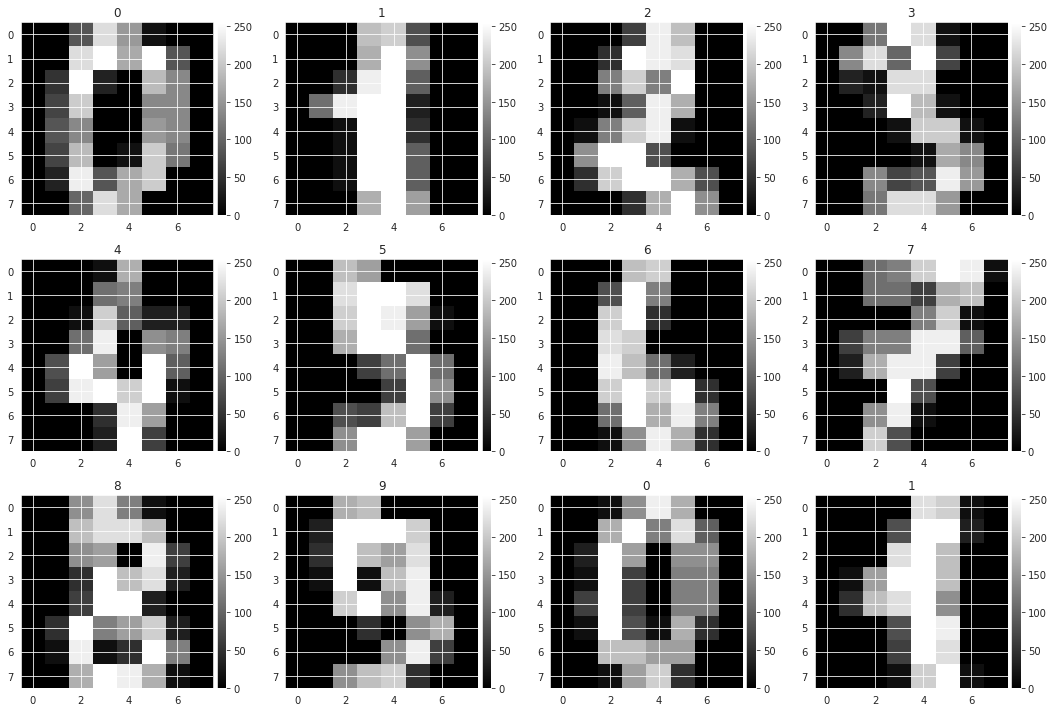

In [82]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

digits = load_digits()
data = digits.data
labels = digits.target
n, d = data.shape

ncols, nrows = 4, 3
fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(spec[i, j])
        ax.set_title(labels[i * ncols + j])
        img = (data[i * ncols + j]*(255/data[i * ncols + j].max())).astype(int)
        ski.io.imshow(img.reshape(8,8), ax=ax, cmap="gray")

### b) Mit SVM-Klassifikator arbeiten

In [83]:
def shuffle(data, labels):
    mixer = list(zip(data, labels))
    random.shuffle(mixer)
    data, labels = zip(*mixer)
    return data, labels

In [84]:
def sample_data(n_test, data, labels):
    n_train = 1 - n_test
    train_data = data[:n_train]
    test_data = data[n_train:]
    train_labels = labels[:n_train]
    test_labels = labels[n_train:]
    return train_data, test_data, train_labels, test_labels

In [85]:
def train_svm(train_data, train_labels, test_data, test_labels, C, gamma, precision=4, printout=False):
    svm = SVC(C=C, gamma=gamma)
    svm.fit(train_data, train_labels)
    train_score = np.round(svm.score(train_data, train_labels), precision)
    test_score = np.round(svm.score(test_data, test_labels), precision)

    if printout:
        if train_score < test_score:
            print("Underfitting! Train score is smaller then test score. train: {}, test: {}".format(train_score, test_score))
        elif train_score > test_score:
            print("Overfitting! Train score is higher then test score. train: {}, test: {}".format(train_score, test_score))
        else:
            print("Perfect! Train score is equal to the test score. train: {}, test: {}".format(train_score, test_score))   
    
    return train_score, test_score

In [86]:
data, labels = shuffle(data, labels)
train_data, test_data, train_labels, test_labels = sample_data(int(n * 0.25), data, labels)

C = 1.0
gamma = 0.015
train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)
    
C = 100
gamma = 0.001
_, _ = train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)

Overfitting! Train score is higher then test score. train: 1.0, test: 0.5246
Overfitting! Train score is higher then test score. train: 1.0, test: 0.9911


## 2. Kreuzvalidierung und Modellselektion

### a) SVM mit verschiedenen Splits

In [87]:
C = 100
gamma = 0.001
for i in range(3):
    data, labels = shuffle(data, labels)
    train_data, test_data, train_labels, test_labels = sample_data(int(n * 0.25), data, labels)
    train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)

Overfitting! Train score is higher then test score. train: 1.0, test: 0.9911
Overfitting! Train score is higher then test score. train: 1.0, test: 0.9888
Overfitting! Train score is higher then test score. train: 1.0, test: 0.9911


### b) Kreuzvalidierung mit SciKit-Methode

In [88]:
C = 100
gamma = 0.001
svm = SVC(C=C, gamma=gamma)
scores = cross_val_score(svm, train_data, train_labels, cv=10)
mean = np.mean(scores)
std = np.std(scores)
print(scores)
print("mean: {}, std: {}".format(mean, std))

[0.98571429 0.98550725 0.98550725 0.99264706 1.         1.         0.98507463 1.         0.99236641 0.97692308]
mean: 0.9903739953293927, std: 0.0075180471996705136


### c) GridSearch von "Hand"

In [89]:
n_small = 500
data_small = data[:n_small]
labels_small = labels[:n_small]

n_Cs = 5
min_C, max_C = 1, 200
Cs = np.linspace(min_C, max_C, n_Cs)

n_gammas = 5
min_gamma, max_gamma = -7, -1
gammas = np.logspace(min_gamma,  max_gamma, n_gammas)

n_test = int(n_small * 0.25)
n_splits = 3

plot_data_train = np.zeros(shape=(n_gammas, n_Cs), dtype=np.float)
plot_data_test = np.zeros(shape=(n_gammas, n_Cs), dtype=np.float)

for i, gamma in enumerate(gammas):
    for j, C in enumerate(Cs):
        scores_train = 0.0
        scores_test = 0.0
        for _ in range(n_splits):
            data_small, labels_small = shuffle(data_small, labels_small)
            train_data, test_data, train_labels, test_labels = sample_data(n_test, data_small, labels_small)
            train_score, test_score = train_svm(train_data, train_labels, test_data, test_labels, C, gamma)
            scores_train += train_score
            scores_test += test_score
        plot_data_train[i, j] = (scores_train/n_splits)
        plot_data_test[i, j] = (scores_test/n_splits)

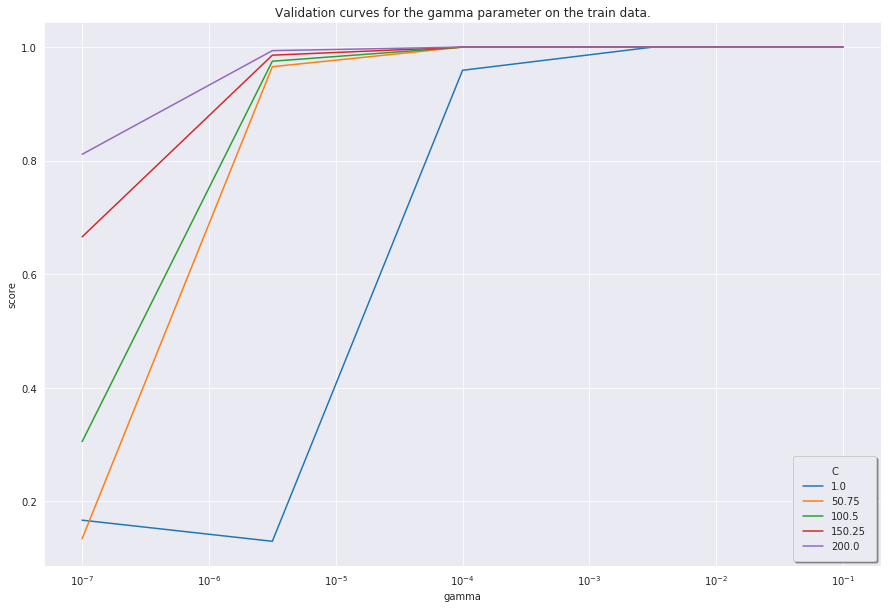

In [90]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
for i, C in enumerate(Cs):
    ax = sns.lineplot(x=gammas, y=plot_data_train[:, i], label=C)
    ax.set(xscale="log")
    ax.set_title('Validation curves for the gamma parameter on the train data.');
    ax.set_xlabel("gamma")
    ax.set_ylabel("score")
    ax.legend(loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="C")

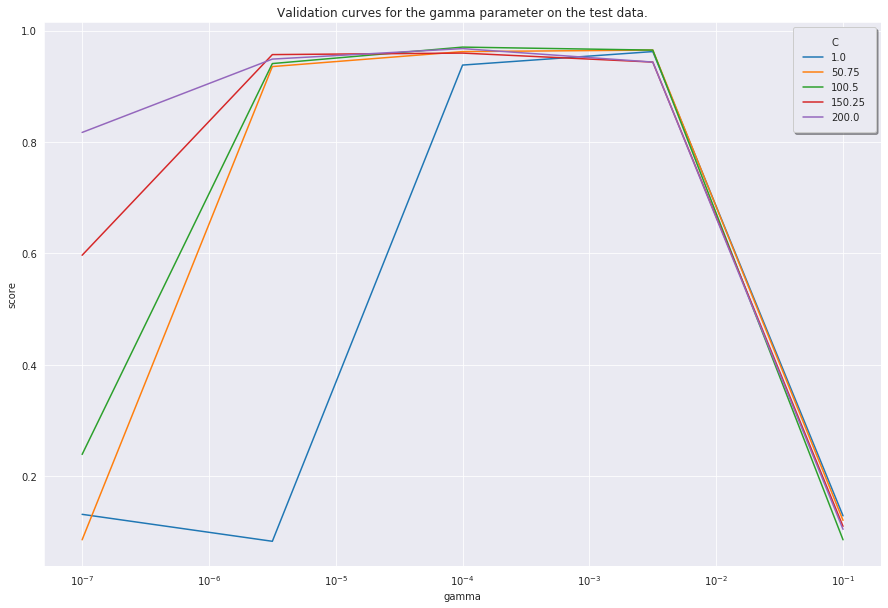

In [91]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
for i, C in enumerate(Cs):
    ax = sns.lineplot(x=gammas, y=plot_data_test[:, i], label=C)
    ax.set(xscale="log")
    ax.set_title('Validation curves for the gamma parameter on the test data.');
    ax.set_xlabel("gamma")
    ax.set_ylabel("score")
    ax.legend(loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="C")

<IPython.core.display.Javascript object>


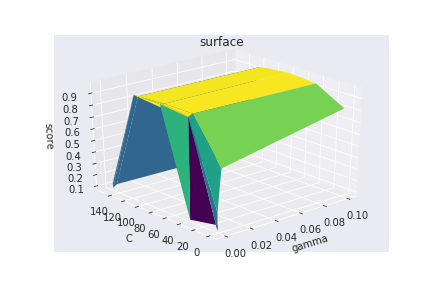

Text(0.5, 0, 'score')

In [102]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(gammas, Cs)
ax.plot_surface(X, Y, plot_data_test, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.set_title('surface')
ax.set_xlabel("gamma")
ax.set_ylabel("C")
ax.set_zlabel("score")

### d) GridSearch mit SciKit

In [94]:
n_small = 500
data_small = data[:n_small]
labels_small = labels[:n_small]
data_small, labels_small = shuffle(data_small, labels_small)

n_Cs = 5
min_C, max_C = 1, 150
Cs = np.linspace(min_C, max_C, n_Cs)

n_gammas = 5
min_gamma, max_gamma = -7, -1
gammas = np.logspace(min_gamma,  max_gamma, n_gammas)

n_test = int(n_small * 0.25)
n_splits = 3

train_data, test_data, train_labels, test_labels = sample_data(n_test, data_small, labels_small)

svc_params = {'C': Cs,'gamma': gammas}
gridsvm = sklearn.model_selection.GridSearchCV(SVC(), param_grid=svc_params, cv=n_splits)
gridsvm.fit(train_data, train_labels)
print(f"Best parameters: {gridsvm.best_params_}")
print(f"Best score: {gridsvm.best_score_}")
print()
y_true, y_pred = test_labels, gridsvm.predict(test_data)
print("Classification report:")
print(classification_report(y_true, y_pred))

Best parameters: {'C': 38.25, 'gamma': 0.0001}
Best score: 0.9680851063829787

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        12
           3       0.85      0.85      0.85        13
           4       1.00      1.00      1.00        16
           5       0.88      1.00      0.94        15
           6       1.00      1.00      1.00        16
           7       0.94      1.00      0.97        16
           8       1.00      0.85      0.92        13
           9       1.00      0.86      0.92         7

    accuracy                           0.96       124
   macro avg       0.97      0.95      0.96       124
weighted avg       0.96      0.96      0.96       124



/home/henning/anaconda3/envs/base_mldl/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 3. Klassifikation mit Random Forests und Boosting

### a) Klassifikator mit Random Forest

### b) Random Forest mit Boosting

### OPTIONAL: GridSearch für Random Forest mit Boosting 